In [22]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("awsaf49/food-recognition-2022-dataset")

# print("Path to dataset files:", path)

In [2]:
import torch
import os
import joblib
import json
from fastprogress import master_bar, progress_bar
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
from PIL import Image

print(torchvision.__version__)

0.19.0


In [6]:
# detectron segemntation model used for key object detection, and semantic segmentation.

In [23]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5fo0ixt9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5fo0ixt9
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done


In [24]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


<_Logger detectron2 (DEBUG)>

In [8]:
detectron2.__version__

'0.6'

In [10]:
import subprocess
from pathlib import Path

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import Boxes, BoxMode 
import pycocotools.mask as mask_util

from pprint import pprint
from collections import OrderedDict
import plotly.graph_objects as go
import plotly.express as px

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
train_root = r"/kaggle/input/food-recognition-2022-dataset/public_training_set_release_2.0"
val_root =  r"/kaggle/input/food-recognition-2022-dataset/public_validation_set_2.0"

train_images = train_root + "/images/"
val_images = val_root + "/images/"

train_annot = '/kaggle/input/annoted-dataset/xyz/train.json'
val_annot = '/kaggle/input/annoted-dataset/xyz/val.json'

In [28]:
# def resize_images(annotations, dir_path, VERBOSE = False):
#     for n, i in enumerate(tqdm((annotations['images']))):
#         img = cv2.imread(dir_path+i["file_name"])
#         if img.shape[0] != i['height']:
#             annotations['images'][n]['height'] = img.shape[0]
#             if VERBOSE:
#                 print(i["file_name"])
#                 print(annotations['images'][n], img.shape)

#         if img.shape[1] != i['width']:
#             annotations['images'][n]['width'] = img.shape[1]
#             if VERBOSE:
#                 print(i["file_name"])
#                 print(annotations['images'][n], img.shape)

#     return annotations
# with open(train_annot) as f:
#     train_annotations_data = json.load(f)

# with open(val_annot) as f:
#     val_annotations_data = json.load(f)

In [29]:
# train_annotation_data_path = resize_images(train_annotations_data, train_images)
# with open(newtrain_annot, 'w') as f:
#     json.dump(train_annotation_data_path,f)
# val_annotation_data_path = resize_images(val_annotations_data, val_images)
# with open(newval_annot, 'w') as f:
#     json.dump(val_annotation_data_path,f)

In [30]:
annotation_path = "/kaggle/working/train.json"
json_file = open(annotation_path)
food = json.load(json_file)
print(food["categories"])
classes_names = [category["name"] for category in food["categories"]]

[{'id': 1565, 'name': 'bread-wholemeal', 'name_readable': 'Bread, wholemeal', 'supercategory': 'food'}, {'id': 2099, 'name': 'jam', 'name_readable': 'Jam', 'supercategory': 'food'}, {'id': 2578, 'name': 'water', 'name_readable': 'Water', 'supercategory': 'food'}, {'id': 1556, 'name': 'bread-sourdough', 'name_readable': 'Bread, sourdough', 'supercategory': 'food'}, {'id': 1154, 'name': 'banana', 'name_readable': 'Banana', 'supercategory': 'food'}, {'id': 1352, 'name': 'soft-cheese', 'name_readable': 'Soft cheese', 'supercategory': 'food'}, {'id': 1893, 'name': 'ham-raw', 'name_readable': 'Ham, raw', 'supercategory': 'food'}, {'id': 1310, 'name': 'hard-cheese', 'name_readable': 'Hard cheese', 'supercategory': 'food'}, {'id': 1264, 'name': 'cottage-cheese', 'name_readable': 'Cottage cheese', 'supercategory': 'food'}, {'id': 1536, 'name': 'bread-half-white', 'name_readable': 'Bread, half white', 'supercategory': 'food'}, {'id': 2512, 'name': 'coffee-with-caffeine', 'name_readable': 'Coffee

In [48]:
food

{'categories': [{'id': 1565,
   'name': 'bread-wholemeal',
   'name_readable': 'Bread, wholemeal',
   'supercategory': 'food'},
  {'id': 2099, 'name': 'jam', 'name_readable': 'Jam', 'supercategory': 'food'},
  {'id': 2578,
   'name': 'water',
   'name_readable': 'Water',
   'supercategory': 'food'},
  {'id': 1556,
   'name': 'bread-sourdough',
   'name_readable': 'Bread, sourdough',
   'supercategory': 'food'},
  {'id': 1154,
   'name': 'banana',
   'name_readable': 'Banana',
   'supercategory': 'food'},
  {'id': 1352,
   'name': 'soft-cheese',
   'name_readable': 'Soft cheese',
   'supercategory': 'food'},
  {'id': 1893,
   'name': 'ham-raw',
   'name_readable': 'Ham, raw',
   'supercategory': 'food'},
  {'id': 1310,
   'name': 'hard-cheese',
   'name_readable': 'Hard cheese',
   'supercategory': 'food'},
  {'id': 1264,
   'name': 'cottage-cheese',
   'name_readable': 'Cottage cheese',
   'supercategory': 'food'},
  {'id': 1536,
   'name': 'bread-half-white',
   'name_readable': 'Brea

In [49]:
from collections import OrderedDict
import pandas as pd

categories = food["categories"]
class_names = [category["name"] for category in categories]
category_ids = [category["id"] for category in categories]

no_images_per_category = {}
image_data = []  # List to store image information

for n, cat_id in enumerate(category_ids):
    img_ids = [ann['image_id'] for ann in food['annotations'] if ann['category_id'] == cat_id]
    label = class_names[n]
    no_images_per_category[label] = len(img_ids)

    # Load image information for each image ID
    for img_id in img_ids:
        img_info = next((img for img in food['images'] if img['id'] == img_id), None)
        if img_info:
            image_data.append({
                'file_name': img_info['file_name'],
                'height': img_info['height'],
                'width': img_info['width'],
                'id': img_info['id'],
                'category': label
            })

# Create a DataFrame from the image data
df_image_info = pd.DataFrame(image_data)

# Sort the no_images_per_category dictionary by the number of images
no_images_per_category = OrderedDict(sorted(no_images_per_category.items(), key=lambda x: -1 * x[1]))


top_30_categories = []
i = 0
for k, v in no_images_per_category.items():
    print(k, v)
    top_30_categories.append((k, v))
    i += 1
    if i >= 30:
        break

water 5283
salad-leaf-salad-green 2034
bread-white 1992
coffee-with-caffeine 1991
tomato-raw 1908
butter 1671
bread-wholemeal 1504
carrot-raw 1504
egg 1069
rice 1032
apple 972
mixed-vegetables 908
wine-red 868
jam 853
cucumber 757
banana 736
espresso-with-caffeine 695
potatoes-steamed 677
cheese 660
tea 602
bell-pepper-red-raw 572
hard-cheese 563
white-coffee-with-caffeine 533
bread-whole-wheat 525
mixed-salad-chopped-without-sauce 505
wine-white 492
avocado 491
tomato-sauce 475
broccoli 431
strawberries 430


In [50]:
df_image_info.to_csv('/kaggle/working/cat_image.csv')

In [51]:
cat = pd.read_csv("/kaggle/working/cat_image.csv")
cat[:5]

,Unnamed: 0,file_name,height,width,id,category
0,0,131094.jpg,480,480,131094,bread-wholemeal
1,1,132123.jpg,464,464,132123,bread-wholemeal
2,2,132325.jpg,400,401,132325,bread-wholemeal
3,3,132427.jpg,400,401,132427,bread-wholemeal
4,4,132512.jpg,513,512,132512,bread-wholemeal


In [52]:
cat.drop("Unnamed: 0",axis=1,inplace=True)

In [36]:
fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[:50], y=list(no_images_per_category.values())[:50])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[50:200], y=list(no_images_per_category.values())[50:200])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[200:], y=list(no_images_per_category.values())[200:])])
fig.update_layout(
    title="No of Image per class",)

In [54]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=cat['height'],text='height'))
fig.add_trace(go.Histogram(x=cat['width'],text='width'))

# Overlay both histograms
fig.update_layout(barmode='stack', title="Histogram of Image width & height",)


fig.show()

In [55]:
cat.describe()

,height,width,id
count,76491.000000,76491.000000,76491.000000
mean,658.209593,653.751592,87043.895909
std,313.231762,284.974629,52790.957660
min,183.000000,182.000000,6316.000000
25%,464.000000,464.000000,38165.500000
50%,480.000000,480.000000,83315.000000
75%,853.000000,853.000000,133868.000000
max,4608.000000,4128.000000,185902.000000


In [56]:
cat.isna().sum()

file_name    0
height       0
width        0
id           0
category     0
dtype: int64

In [61]:
train_annotation_data = json.load(open(annotation_path))
annot_id = train_annotation_data['images'][0]['id']
annot_id

131094

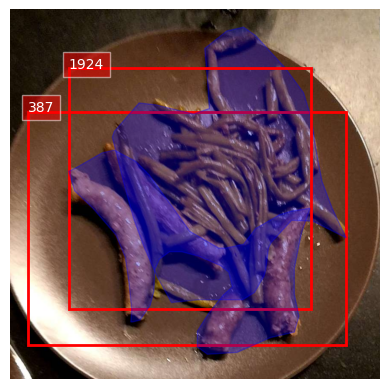

In [66]:
import matplotlib.patches as patches

train_annotation_data = json.load(open(annotation_path))
img_no = 12

selected_image = train_annotation_data['images'][img_no]
img_id = selected_image['id']
img_file_name = selected_image['file_name']

annotations = [
    ann for ann in train_annotation_data['annotations'] if ann['image_id'] == img_id
]

image_path = train_images + img_file_name
image = plt.imread(image_path)

fig, ax = plt.subplots(1)
ax.imshow(image)
plt.axis('off')

for ann in annotations:
    bbox = ann['bbox']
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

    if 'segmentation' in ann:
        for seg in ann['segmentation']:
            poly = np.array(seg).reshape(-1, 2)
            ax.fill(poly[:, 0], poly[:, 1], color='blue', alpha=0.3)  
    if 'category_id' in ann:
        category_id = ann['category_id']
        ax.text(bbox[0], bbox[1], str(category_id), color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

plt.show()


In [67]:
from fastai.vision.core import *
from fastai.vision.utils import *
from fastai.vision.augment import *
from fastai.data.core import *
from fastai.data.transforms import *

In [69]:
images, lbl_bbox = get_annotations(annotation_path)

In [70]:
images[0],lbl_bbox[0]

('131094.jpg',
 ([[39.5, 39.5, 206.5, 131.5],
   [8.2599609375, 8.2599609375, 375.07999877929694, 196.6599609375],
   [23.479998779296878,
    86.25996093750001,
    241.05996093750002,
    241.05996093750002],
   [239.4799987792969, 243.4599609375, 455.47999877929686, 472.65996093750005],
   [127.87999877929687,
    263.8599609375,
    370.65996093750005,
    370.65996093750005],
   [148.2799987792969, 333.4599609375, 458.25996093749995, 470.2599609375]],
  ['soft-cheese',
   'ham-raw',
   'hard-cheese',
   'bread-wholemeal',
   'cottage-cheese',
   'bread-half-white']))

In [76]:
cat.columns

Index(['file_name', 'height', 'width', 'id', 'category'], dtype='object')

In [77]:
cat.drop("category",axis=1,inplace=True)

In [78]:
cat.columns

Index(['file_name', 'height', 'width', 'id'], dtype='object')

In [96]:
idx=20
img_fn,bbox = images[idx],lbl_bbox[idx]

img_fn,bbox

('131273.jpg', ([[46.5, 46.5, 416.5, 431.5]], ['soup-cream-of-vegetables']))

In [88]:
coordinates=bbox[0][0]
print(coordinates)

[46.5, 46.5, 416.5, 431.5]


In [97]:
def extract_img_data(bbox):
    label = img_fn
    coordinates = bbox[0][0]
    x_min, y_min, width, height = coordinates
    return {
        'bbox': (x_min, y_min, width, height),
        'label': label
    }

food_data = extract_img_data(bbox)
food_data

{'bbox': (46.5, 46.5, 416.5, 431.5), 'label': '131273.jpg'}

In [98]:
bounding_box = food_data['bbox']
label = food_data['label']

print(f"Image Path: {img_fn}")
print(f"Bounding Box: {bounding_box}")
print(f"Label: {label}")

Image Path: 131273.jpg
Bounding Box: (46.5, 46.5, 416.5, 431.5)
Label: 131273.jpg


In [99]:
np.array(train_annotation_data['annotations'][2]['segmentation']).shape , np.array(train_annotation_data['annotations'][2]['bbox']).shape

((1, 38), (4,))

In [101]:
# Detectron model for resnet50
config = get_cfg()

MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
config.merge_from_file(model_zoo.get_config_file(MODEL_ARCH))

In [103]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("training_dataset", {},train_annot, train_images)
register_coco_instances("validation_dataset", {},val_annot, val_images)

In [109]:
config.DATASETS.TRAIN = ("training_dataset",)
config.DATASETS.TEST = ("validation_dataset",)

In [110]:
config.DATALOADER.NUM_WORKERS = 2
config.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_ARCH)

In [126]:
config.SOLVER.IMS_PER_BATCH = 4
config.SOLVER.BASE_LR = 0.003
config.SOLVER.MAX_ITER = 200000

config.SOLVER.CHECKPOINT_PERIOD = 2
config.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
config.MODEL.ROI_HEADS.NUM_CLASSES = 498

In [127]:
config.OUTPUT_DIR = "model_logs/"
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

In [128]:
trainer = DefaultTrainer(config) 
trainer.resume_or_load(resume=False)

[10/25 19:13:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [114]:
from torch.utils import tensorboard
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

In [115]:
writer = SummaryWriter()

In [129]:
trainer.train()

[10/25 19:13:32 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/25 19:14:56 d2.utils.events]:  eta: 7 days, 0:01:06  iter: 19  total_loss: 2.739  loss_cls: 1.414  loss_box_reg: 0.6494  loss_mask: 0.6845  loss_rpn_cls: 0.01265  loss_rpn_loc: 0.0155    time: 3.1905  last_time: 2.8923  data_time: 0.0460  last_data_time: 0.0146   lr: 5.9943e-05  max_mem: 11416M
[10/25 19:16:22 d2.utils.events]:  eta: 7 days, 1:42:39  iter: 39  total_loss: 2.668  loss_cls: 1.261  loss_box_reg: 0.6359  loss_mask: 0.6843  loss_rpn_cls: 0.00916  loss_rpn_loc: 0.01149    time: 3.1434  last_time: 2.8165  data_time: 0.0346  last_data_time: 0.0107   lr: 0.00011988  max_mem: 11416M
ERROR [10/25 19:16:50 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/serialization.py", line 652, in save
    _save(obj, opened_zipfile, pickle_module, pickle_protocol, _disable_byteorder_record)
  File "/opt/conda/lib/python3.10/site-packages/torch/serialization.py", line 886, in _save
    zip_file.write_

RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 626404032 vs 626403920

In [118]:
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01

config.MODEL.WEIGHTS = os.path.join(config.OUTPUT_DIR, "model_final.pth")

evaluator = COCOEvaluator("validation_dataset", config, False, output_dir=config.OUTPUT_DIR)
val_loader = build_detection_test_loader(config, "validation_dataset")
valResults = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/25 19:01:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [10/25 19:01:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 19:01:52 d2.data.datasets.coco]: Loaded 1000 images in COCO format from /kaggle/input/annoted-dataset/xyz/val.json
[10/25 19:01:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/25 19:01:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/25 19:01:53 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[10/25 19:01:53 d2.data.common]: Serialized dataset takes 1.64 MiB
[10/25 19:01:53 d2.evaluation.evaluator]: Start inference on 1000 batches


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/25 19:01:55 d2.evaluation.evaluator]: Inference done 11/1000. Dataloading: 0.0015 s/iter. Inference: 0.1938 s/iter. Eval: 0.0001 s/iter. Total: 0.1954 s/iter. ETA=0:03:13
[10/25 19:02:00 d2.evaluation.evaluator]: Inference done 37/1000. Dataloading: 0.0019 s/iter. Inference: 0.1965 s/iter. Eval: 0.0001 s/iter. Total: 0.1987 s/iter. ETA=0:03:11
[10/25 19:02:05 d2.evaluation.evaluator]: Inference done 62/1000. Dataloading: 0.0018 s/iter. Inference: 0.1995 s/iter. Eval: 0.0001 s/iter. Total: 0.2015 s/iter. ETA=0:03:09
[10/25 19:02:10 d2.evaluation.evaluator]: Inference done 86/1000. Dataloading: 0.0018 s/iter. Inference: 0.2017 s/iter. Eval: 0.0001 s/iter. Total: 0.2037 s/iter. ETA=0:03:06
[10/25 19:02:16 d2.evaluation.evaluator]: Inference done 110/1000. Dataloading: 0.0018 s/iter. Inference: 0.2041 s/iter. Eval: 0.0001 s/iter. Total: 0.2061 s/iter. ETA=0:03:03
[10/25 19:02:21 d2.evaluation.evaluator]: Inference done 134/1000. Dataloading: 0.0018 s/iter. Inference: 0.2050 s/iter. Eva

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[10/25 19:05:15 d2.evaluation.evaluator]: Total inference time: 0:03:20.881268 (0.201891 s / iter per device, on 1 devices)
[10/25 19:05:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:03:18 (0.199720 s / iter per device, on 1 devices)
[10/25 19:05:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/25 19:05:15 d2.evaluation.coco_evaluation]: Saving results to model_logs/coco_instances_results.json
[10/25 19:05:15 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
WARNING [10/25 19:05:15 d2.evaluation.coco_evaluation]: No predictions from the model!


In [121]:
config.MODEL.WEIGHTS = os.path.join(config.OUTPUT_DIR, "model_final.pth")
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01
config.MODEL.ROI_HEADS.NUM_CLASSES = 498

config.DATASETS.TEST = ("validation_dataset", )
predictor = DefaultPredictor(config)

[10/25 19:08:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_logs/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



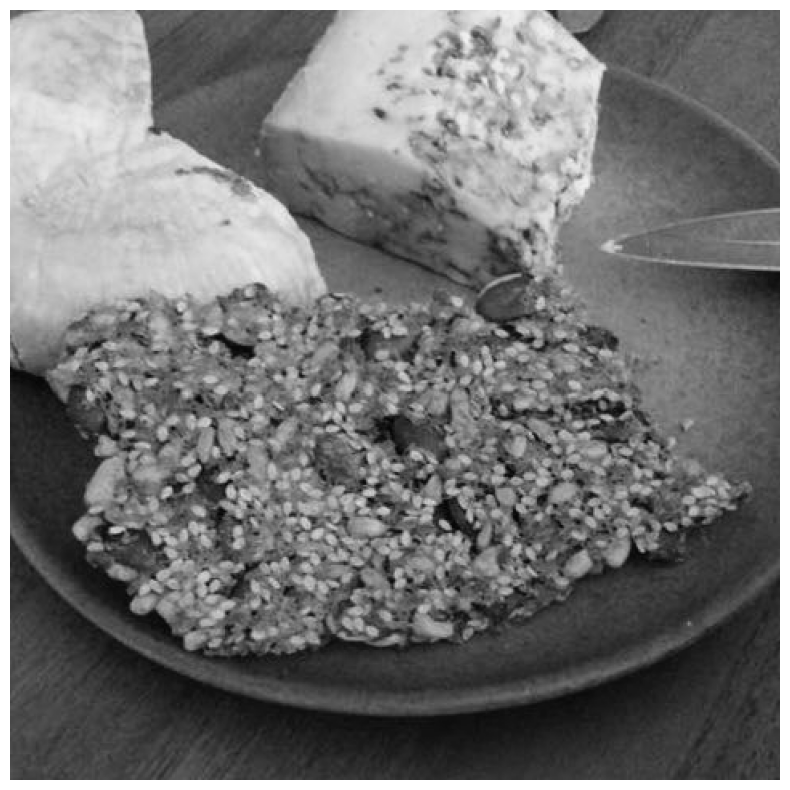

In [125]:
val_metadata = MetadataCatalog.get("validation_dataset")
im = cv2.imread("/kaggle/input/food-recognition-2022-dataset/public_test_release_2.0/images/007997.jpg")

outputs = predictor(im)


v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off') 
plt.show()